In [59]:
# Graphing
import requests
import networkx as nx
import matplotlib.pyplot as plt
import csv
from math import pi, sqrt
from tabulate import tabulate
import numpy as np
import powerlaw

# Co Occurences
import json
from datetime import datetime
from collections import defaultdict
import seaborn as sns

# Sentimental Analysis
import nltk
import pandas as pd
import numpy as np
import requests
import networkx as nx
import re
import matplotlib.pyplot as plt
import os
import pickle
from nltk.stem import WordNetLemmatizer

# Graphing of the social network of Game of Thrones

In [2]:
# Functions section

# Function to fetch links from a character's Game of Thrones Fandom Wiki page
def get_character_links(character_name):
    base_url = "https://gameofthrones.fandom.com/api.php"
    params = {
        "action": "parse",
        "page": character_name,
        "prop": "links",
        "format": "json",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    links = []

    if "parse" in data and "links" in data["parse"]:
        links = [link["*"] for link in data["parse"]["links"] if link["*"] in character_names]

    return links

# Function to find indegree and outdegree of a network
def in_out_degrees(G):
    nodes = [node for node in G.nodes()]
    in_degrees = dict(G.in_degree(nodes))
    out_degrees = dict(G.out_degree(nodes))

    in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

    return in_degrees, out_degrees

In [3]:
# Load the CSV file with the Game of Thrones characters' names
character_names = []

with open("characters_v4.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        character_names.append(row[0])

# Create a directed NetworkX graph
G = nx.DiGraph()

for character_name in character_names:
    G.add_node(character_name)

# Populate the graph with directed edges between characters
for character_name in character_names:
    character_links = get_character_links(character_name)
    for link in character_links:
        G.add_edge(character_name, link)

In [4]:
# Save the graph in a GraphML file
nx.write_graphml(G, "got_network.graphml")

In [2]:

# If you have already saved the graph, you can load it from the file
G = nx.read_graphml("got_network.graphml")

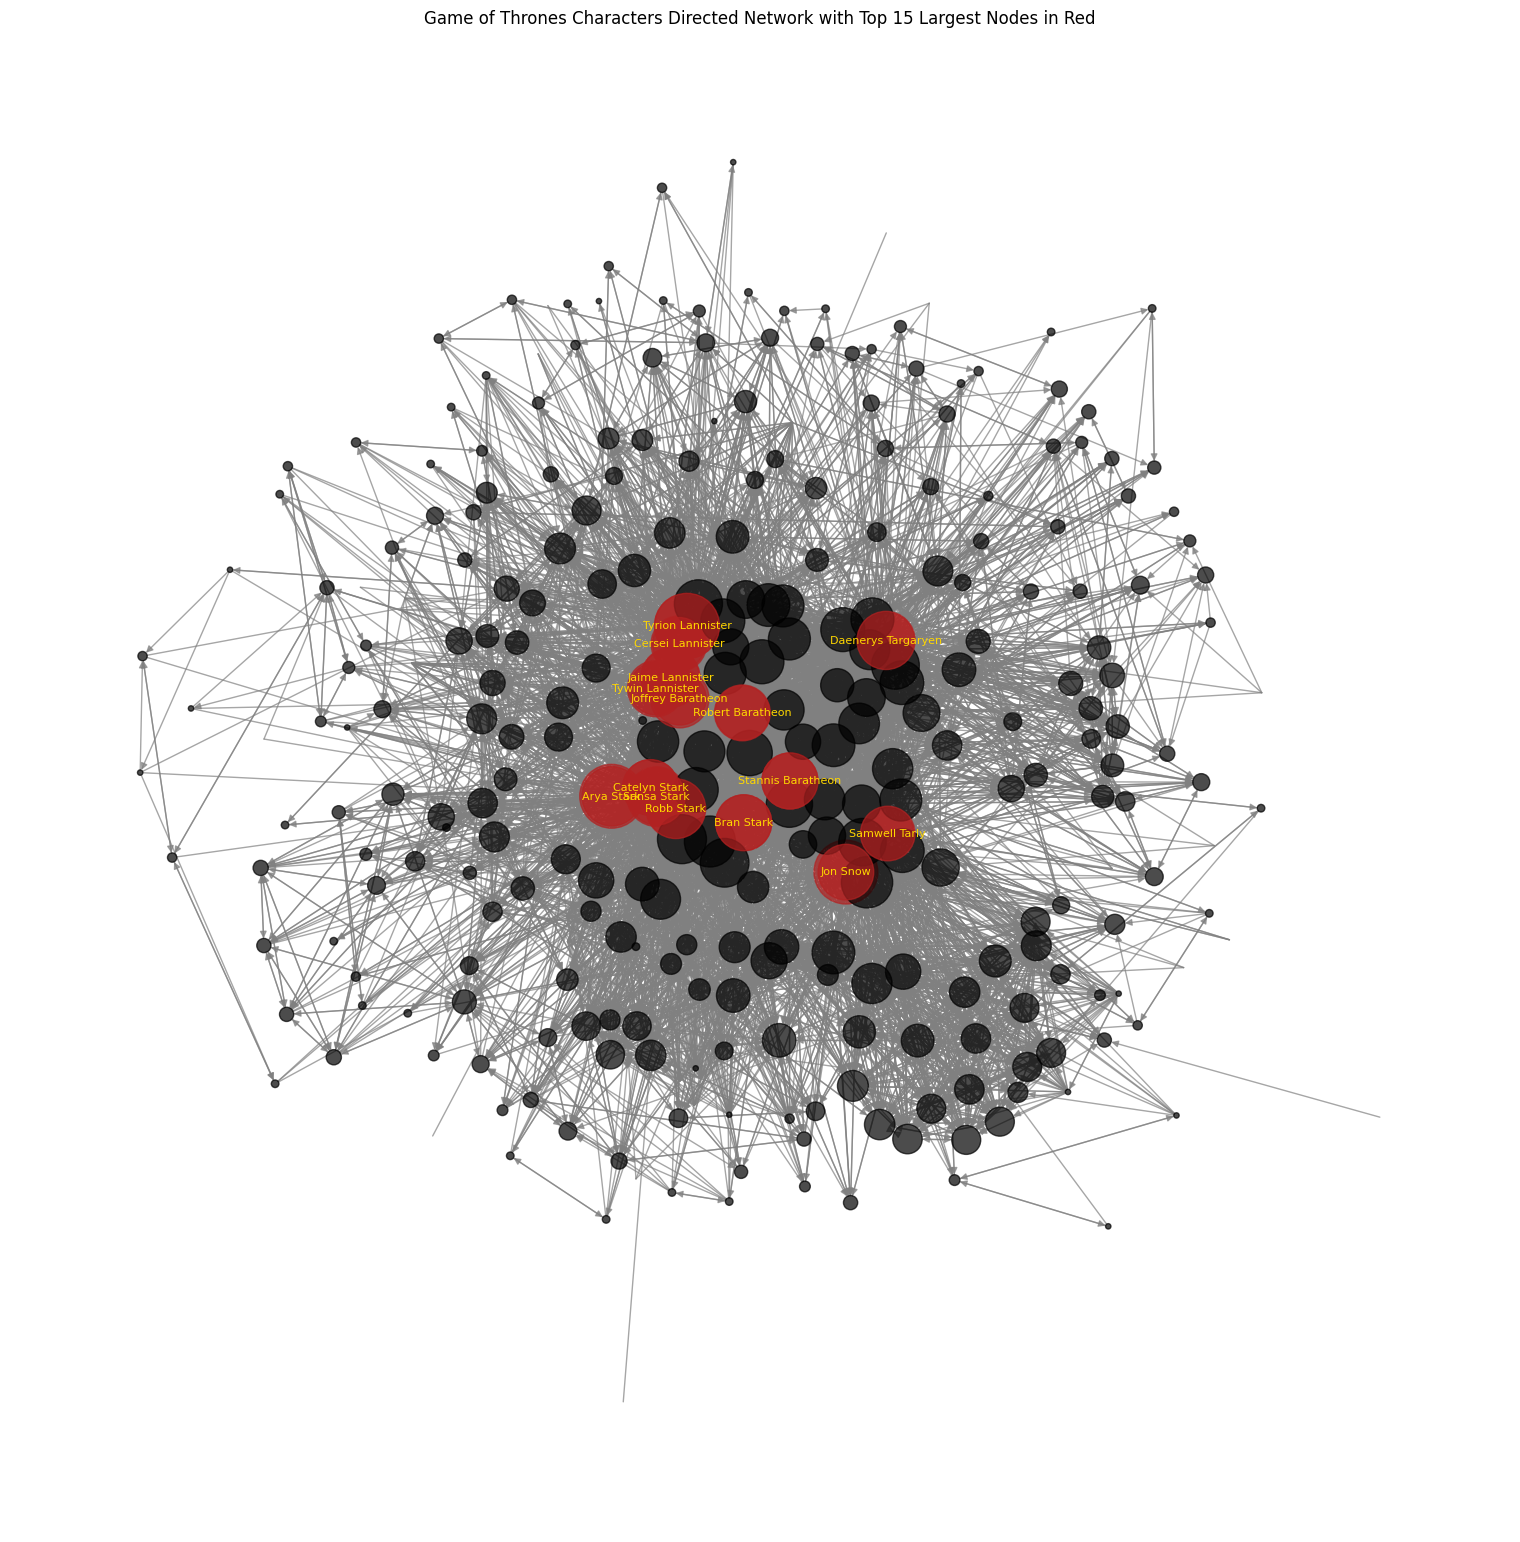

In [4]:
# Calculate in-degrees
in_degrees = G.in_degree()

# Determine the 15 nodes with the highest in-degrees
top_15_nodes = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:15]

# Create a list of labels for the 15 biggest nodes
node_labels = {}
for node, in_degree in top_15_nodes:
    node_labels[node] = node

# Calculate node sizes based on in-degrees
node_sizes = [in_degree * 15 for _, in_degree in in_degrees]

# Use the Kamada-Kawai layout algorithm for node positioning
pos = nx.kamada_kawai_layout(G)

# Increase the figure size for better visualization
plt.figure(figsize=(15, 15))

# Specify a different color for the 15 largest nodes
node_colors = ["firebrick" if node in [node for node, _ in top_15_nodes] else "black" for node in G.nodes()]

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Draw nodes with sizes and labels for all nodes except the top 15
nx.draw(G, 
        pos=pos, 
        with_labels=False, 
        node_size=node_sizes, 
        node_color=node_colors, 
        edge_color="grey", 
        font_size=10, 
        alpha=0.7,
        arrows=True
    )

# Draw labels for the 15 largest nodes
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='gold')

# Extract information for the top 15 nodes
top_15_node_list = [node for node, _ in top_15_nodes]
top_node_sizes = [size for node, size in zip(G.nodes(), node_sizes) if node in top_15_node_list]

# Draw the top 15 nodes again to ensure they're on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=top_15_node_list, 
                       node_size=top_node_sizes, 
                       node_color="firebrick", 
                       alpha=0.7
                      )

plt.title("Game of Thrones Characters Directed Network with Top 15 Largest Nodes in Red")
plt.show()

Top 5 most connected nodes (characters):

 In Degree                        | Out Degree
----------------------------------+-----------------------------------
 Character        |   In Degree   | Character        |   Out Degree
 ------------------+------------- | ------------------+--------------
 Tyrion Lannister |         145   | Jon Snow         |          125
 Jon Snow         |         140   | Sansa Stark      |           97
 Sansa Stark      |         122   | Tyrion Lannister |           91
 Arya Stark       |         121   | Jaime Lannister  |           91
 Robb Stark       |         117   | Robb Stark       |           90


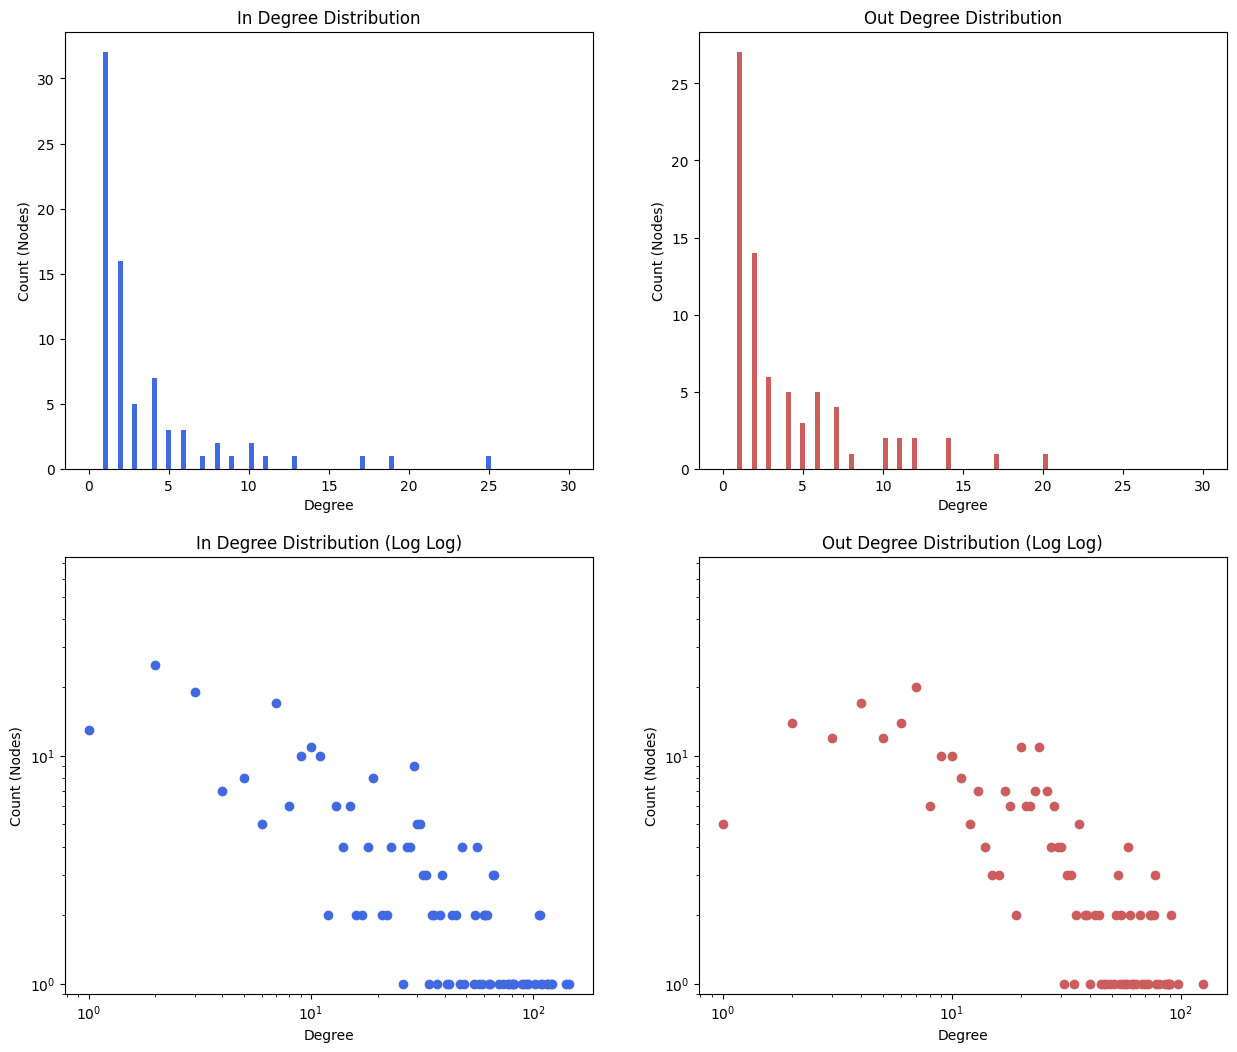

In [12]:
print('Top 5 most connected nodes (characters):\n')
in_degrees, out_degrees = in_out_degrees(G)
in_table = tabulate(in_degrees, headers=['Character', 'In Degree'], tablefmt="presto")
out_table = tabulate(out_degrees, headers=['Character', 'Out Degree'], tablefmt="presto")

table = tabulate([list(item) for item in zip(str(in_table).splitlines(), str(out_table).splitlines())],
                        ["In Degree", "Out Degree"], tablefmt="presto")
print(table)

# In degree distribution
in_degrees = dict(G.in_degree())
in_values = sorted(set(in_degrees.values()))
in_hist = [list(in_degrees.values()).count(x) for x in in_values]

# Out degree distribution
out_degrees = dict(G.out_degree())
out_values = sorted(set(out_degrees.values()))
out_hist = [list(out_degrees.values()).count(x) for x in out_values]

# Bins
bins = np.linspace(0, 30, 100)

plt.figure(figsize=(15, 12.5))
plt.subplot(2, 2, 1)
plt.hist(in_hist, bins=bins, color='royalblue')
plt.title("In Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

plt.subplot(2, 2, 2)
plt.hist(out_hist, bins=bins, color='indianred')
plt.title("Out Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

# Log Log plot
plt.subplot(2, 2, 3)
plt.loglog(in_values, in_hist, 'o', color='royalblue')
plt.title("In Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.subplot(2, 2, 4)
plt.loglog(out_values, out_hist, 'o', color='indianred')
plt.title("Out Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.show()

In [11]:
# Power law fit
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degrees = [in_degree for _, in_degree in in_degrees.items()]
out_degrees = [out_degree for _, out_degree in out_degrees.items()]

in_fit = powerlaw.Fit(in_degrees)
out_fit = powerlaw.Fit(out_degrees)

print("In Degree Power Law Fit")
print("alpha in = ", in_fit.power_law.alpha)
print("alpha out = ", out_fit.power_law.alpha)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In Degree Power Law Fit
alpha in =  3.744274775510896
alpha out =  2.4640203759503483


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


# Co Occurences within Game of Thrones

In [39]:
# Functions section

character_colors = defaultdict(lambda: '#DBA374')

def time_to_seconds(t):
    time = datetime.strptime(t, '%H:%M:%S').time()
    return time.hour*3600 + time.minute*60 + time.second

def seconds_to_time(s):
    return datetime.utcfromtimestamp(s).strftime('%H:%M:%S')

def top_n_characters(matrix, characters, n=50):
    summed_times = [(idx, sum(row)) for (idx, row) in enumerate(matrix)]
    summed_times = sorted(summed_times, key=lambda x: x[1], reverse=True)
    top_n = summed_times[:n]
    top_n = [(characters[idx], time) for (idx, time) in top_n]
    return top_n

def normalize_matrix(matrix):
    normalized_matrix = []
    for row in matrix:
        total = sum(row)
        if total == 0:
            normalized_matrix.append(row)
            continue
        normalized_row = [val/total for val in row]
        normalized_matrix.append(normalized_row)
    return normalized_matrix

def is_symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] != matrix[j][i]:
                return False
    return True

def matrix_eye(matrix):
    eye = [matrix[i][i] for i in range(len(matrix))]
    return any(eye)

def make_graph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    G = nx.Graph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        G.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                G.add_edge(characters[i], characters[j], interaction_time=interaction_time)
    return G

def make_digraph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    DG = nx.DiGraph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        DG.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                DG.add_edge(characters[i], characters[j], interaction_time=interaction_time)
    return DG

def area_to_radius(area):
    return  (area / pi)**0.5

def color_nodes(G):
    colors = []
    for node in G.nodes():
        colors.append(character_colors[node])
    return colors

def draw_graph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [v*0.01 for v in node_sizes]
    edges = G.edges()
    widths = [G[u][v]['interaction_time'] * 35 for u,v in edges]
    k = 1 / sqrt(len(G.nodes())) * 4
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=widths,
    )

def draw_digraph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [area_to_radius(v) * 10 for v in node_sizes]
    edge_widths = [G[u][v]['interaction_time'] * 8 for u,v in G.edges()]
    k = 1 / sqrt(len(G.nodes())) * 5
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=edge_widths,
    )

def episodes_from_season(data, season):
    return [episode for episode in data if episode['seasonNum'] == season]

def make_matrix(episodes, characters):
    # Make a 2d matrix of characters x characters
    matrix = []
    for i in range(len(characters)):
        matrix.append([0]*len(characters))
    
    for episode in episodes:
        for scene in episode['scenes']:
            sceneLength = scene['sceneLength']
            characters_in_scene = scene['characters']
            characters_in_scene = [character['name'] for character in characters_in_scene]

            # Fill in the matrix
            for i in range(len(characters_in_scene)):
                for j in range(len(characters_in_scene)):
                    # Skip diagonal, can be recomputed as sum(row)
                    if i != j:
                        matrix[characters.index(characters_in_scene[i])][characters.index(characters_in_scene[j])] += sceneLength

    return matrix

In [40]:
from collections import defaultdict

episodes_data = json.load(open('../data/raw/episodes.json', 'r'))
characters_data = json.load(open('../data/raw/characters.json', 'r'))
colors = json.load(open('../data/raw/colors.json', 'r'))
colors = colors['houses']

episodes = episodes_data['episodes']
print('Number of episodes:', len(episodes))

characters = set()
characters_by_season = {}

for c in characters:
    character_colors[c]

for episode in episodes:
    season = episode['seasonNum']
    scenes = episode['scenes']
    for scene in scenes:
        scene_length = time_to_seconds(scene['sceneEnd']) - time_to_seconds(scene['sceneStart'])
        scene['sceneLength'] = scene_length
        for character in scene['characters']:
            name = character['name']
            characters.add(name)
            if season not in characters_by_season:
                characters_by_season[season] = set()
            characters_by_season[season].add(name)

# Sort characters characters_by_season
characters = sorted(list(characters))
for season in characters_by_season:
    characters_by_season[season] = sorted(list(characters_by_season[season]))

# Create a dict of character name to color
character_colors = defaultdict(lambda: '#ceccd7')
for character in characters_data['characters']:
    name = character['characterName']

    if name not in characters:
        continue
    
    if 'houseName' in character:
        if isinstance(character['houseName'], list):
            house = character['houseName'][0]
        else:
            house = character['houseName']

        if house in colors:
            character_colors[name] = colors[house]
        else:
            print("WARNING missing color for house:", house)

for c in characters:
    character_colors[c] 

Number of episodes: 73
WARNING missing color for house: Arryn
WARNING missing color for house: Umber
WARNING missing color for house: Tarly


In [41]:

season_1_matrix = make_matrix(episodes_from_season(episodes, 1), characters_by_season[1])
season_2_matrix = make_matrix(episodes_from_season(episodes, 2), characters_by_season[2])
season_3_matrix = make_matrix(episodes_from_season(episodes, 3), characters_by_season[3])
season_4_matrix = make_matrix(episodes_from_season(episodes, 4), characters_by_season[4])
season_5_matrix = make_matrix(episodes_from_season(episodes, 5), characters_by_season[5])
season_6_matrix = make_matrix(episodes_from_season(episodes, 6), characters_by_season[6])
season_7_matrix = make_matrix(episodes_from_season(episodes, 7), characters_by_season[7])
season_8_matrix = make_matrix(episodes_from_season(episodes, 8), characters_by_season[8])

complete_matrix = make_matrix(episodes, characters)

In [42]:
total_time = 0
for episode in episodes:
    for scene in episode['scenes']:
        total_time += scene['sceneLength']
print ('Total time:', total_time)

# Calculate hours, minutes, and seconds
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f'{hours} hours, {minutes} minutes, {seconds} seconds')


Total time: 237423
65 hours, 57 minutes, 3 seconds


In [43]:
top_50_full = top_n_characters(complete_matrix, characters)

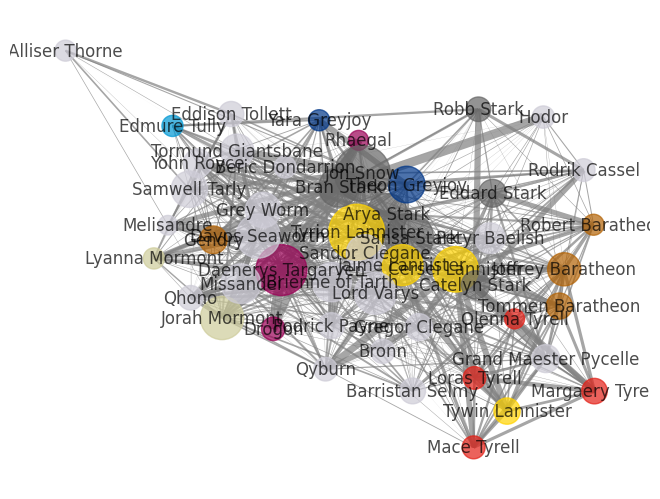

In [50]:
G_S1 = make_graph(season_1_matrix, characters_by_season[1])
G_S2 = make_graph(season_2_matrix, characters_by_season[2])
G_S3 = make_graph(season_3_matrix, characters_by_season[3])
G_S4 = make_graph(season_4_matrix, characters_by_season[4])
G_S5 = make_graph(season_5_matrix, characters_by_season[5])
G_S6 = make_graph(season_6_matrix, characters_by_season[6])
G_S7 = make_graph(season_7_matrix, characters_by_season[7])
G_S8 = make_graph(season_8_matrix, characters_by_season[8])

# Subgraphs
nodes = G_S1.nodes(data=True)
G_S1 = G_S1.subgraph([node[0] for node in nodes])
nodes = G_S2.nodes(data=True)
G_S2 = G_S2.subgraph([node[0] for node in nodes])
nodes = G_S3.nodes(data=True)
G_S3 = G_S3.subgraph([node[0] for node in nodes])
nodes = G_S4.nodes(data=True)
G_S4 = G_S4.subgraph([node[0] for node in nodes])
nodes = G_S5.nodes(data=True)
G_S5 = G_S5.subgraph([node[0] for node in nodes])
nodes = G_S6.nodes(data=True)
G_S6 = G_S6.subgraph([node[0] for node in nodes])
nodes = G_S7.nodes(data=True)
G_S7 = G_S7.subgraph([node[0] for node in nodes])
nodes = G_S8.nodes(data=True)
G_S8 = G_S8.subgraph([node[0] for node in nodes])

# Complete graph
G_complete = make_graph(complete_matrix, characters)
# Limit to top 50 notes
nodes = G_complete.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]['total_time'], reverse=True)[:50]
G_complete_top= G_complete.subgraph([node[0] for node in nodes])
draw_graph(G_complete_top)

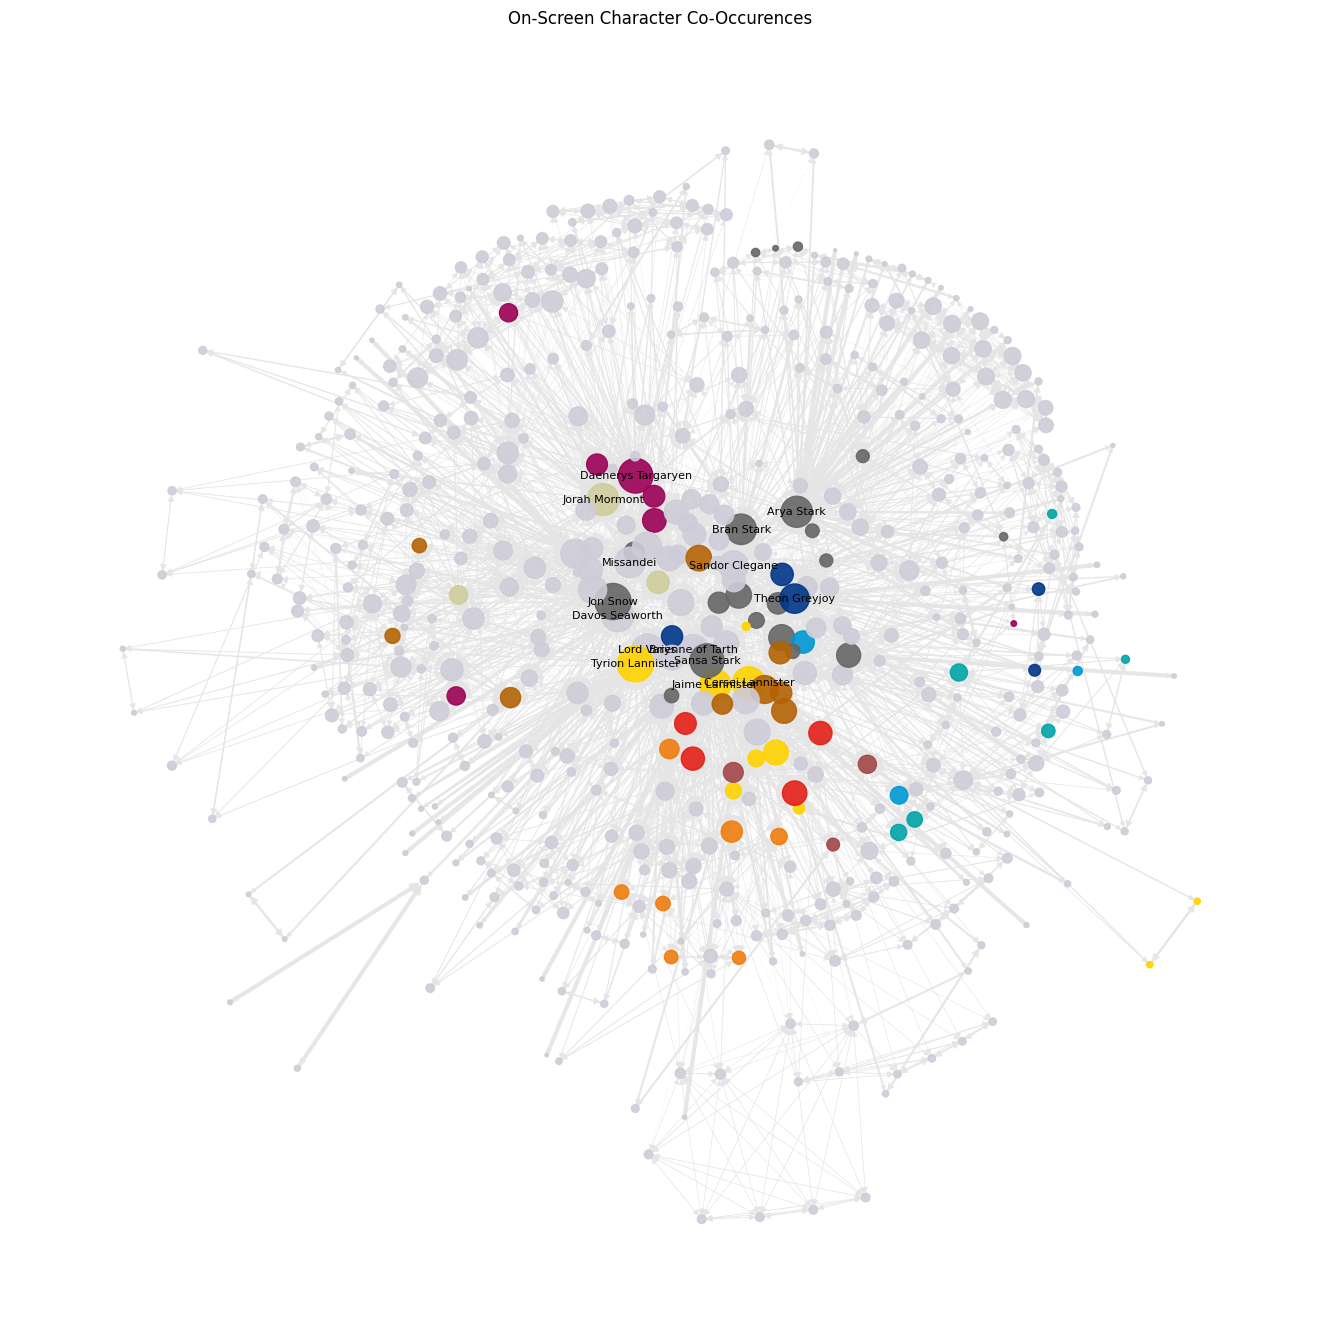

In [51]:
DG_complete = make_digraph(complete_matrix, characters)

top_nodes = sorted(
    G_complete.nodes(data=True), key=lambda x: x[1]["total_time"], reverse=True
)[:15]
top_labels = {node: node for node, _ in top_nodes}

# Parameters
node_scaling = 3
edge_width_scaling = 3
edge_weight_scaling = 0.5

node_sizes = [
    area_to_radius(v) * node_scaling
    for v in nx.get_node_attributes(DG_complete, "total_time").values()
]

# for u, v, data in DG_complete.edges(data=True):
#    data['interaction_time'] *= edge_weight_scaling

edge_widths = [
    DG_complete[u][v]["interaction_time"] * edge_width_scaling
    for u, v in DG_complete.edges()
]
# pos = nx.spring_layout(DG_complete, k=1 / sqrt(len(DG_complete.nodes())) * 6)
pos = nx.kamada_kawai_layout(DG_complete)

plt.figure(figsize=(13, 13))
nx.draw(
    DG_complete,
    pos=pos,
    with_labels=False,
    edge_color="#e5e5e5",#'grey",
    node_size=node_sizes,
    node_color=color_nodes(DG_complete),
    alpha=0.9,
    font_color="black",
    width=edge_widths,
)
nx.draw_networkx_labels(
    DG_complete, pos, labels=top_labels, font_size=8, font_color="black"
)
plt.title("On-Screen Character Co-Occurences")
plt.show()

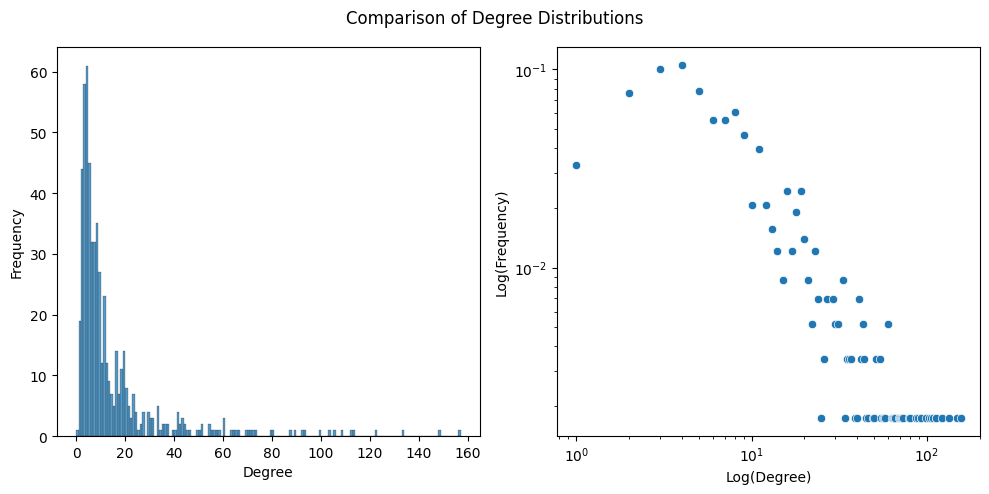

In [52]:
complete_degree_sequence = [d for _, d in G_complete.degree()]
hist, bin_edges = np.histogram(complete_degree_sequence, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2), density=True)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Comparison of Degree Distributions')

sns.histplot(x=complete_degree_sequence, ax=ax0, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2))
ax0.set_xlabel('Degree')
ax0.set_ylabel('Frequency')

sns.scatterplot(x=bin_edges[:-1], y=hist, ax=ax1, marker='o')
plt.xscale('log')
plt.yscale('log')
ax1.set_xlabel('Log(Degree)')
ax1.set_ylabel('Log(Frequency)')

fig.tight_layout()
plt.show()


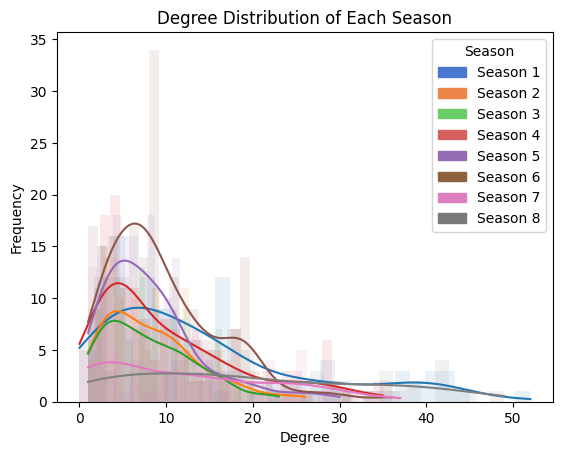

In [53]:
from matplotlib.patches import Patch

def generate_legend():
    # Define your rectangles and corresponding labels
    season_color_palette = sns.palettes.color_palette("muted", 8)
    rectangles = [Patch(color=c, label=f'Season {i+1}') for i, c in enumerate(season_color_palette)]
    return rectangles

season_graphs = [G_S1, G_S2, G_S3, G_S4, G_S5, G_S6, G_S7, G_S8]
season_degrees = zip(
    [f"Season {i}" for i in range(1, len(season_graphs) + 1)],
    [[d for _, d in G_season.degree()] for G_season in season_graphs],
)

for season, degree_sequence in season_degrees:
    sns.histplot(
        degree_sequence,
        bins=30,
        kde=True,
        label=season,
        edgecolor=None,
        alpha=0.1,
        legend=False,
        #kde_kws={'alpha': 0.5}  # Adjust the alpha for KDE
    )

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Each Season")
plt.legend(title="Season", handles=generate_legend(), loc='upper right')

plt.show()


In [88]:
# The most influential characters by highest degree for every season
from tabulate import tabulate

def top_characters_per_season(G, n=10):
    node_degrees = [(node, degree) for node, degree in G.degree()]
    sorted_nodes = sorted(node_degrees, key=lambda x: x[1], reverse=True)

    # Return the top n nodes with their degrees
    return sorted_nodes[:n]

def pp(season, top_characters):
    table = tabulate(top_characters, headers=['Character', 'Degree'], tablefmt="presto")
    print(f"Most influential characters in season {season}:\n\n{table}\n\n")

for i, g in enumerate(season_graphs):
    pp(i+1, top_characters_per_season(g))

top_characters = {c for g in season_graphs for c, _ in top_characters_per_season(g)}

character_names = [
    "Tyrion Lannister",
    "Jaime Lannister",
    "Tywin Lannister",
    "Stannis Baratheon",
    "Daenerys Targaryen",
    "Jon Snow",
    "Arya Stark",
    "Sansa Stark",
    "Robb Stark",
    "Bran Stark",
]

chart_characters = [
    {"Name": "Tyrion Lannister", "Color": "red"},
    {"Name": "Jaime Lannister", "Color": "blue"},
    {"Name": "Tywin Lannister", "Color": "green"},
    {"Name": "Stannis Baratheon", "Color": "cyan"},
    {"Name": "Daenerys Targaryen", "Color": "magenta"},
    {"Name": "Jon Snow", "Color": "orange"},
    {"Name": "Arya Stark", "Color": "purple"},
    {"Name": "Sansa Stark", "Color": "brown"},
    {"Name": "Robb Stark", "Color": "pink"},
    {"Name": "Bran Stark", "Color": "grey"},
]

chart_names = [c["Name"] for c in chart_characters]
for idx, character in enumerate([c["Name"] for c in chart_characters]):
    ranks = []
    for g in season_graphs:
        rank = g.degree(character) if g.has_node(character) else None
        ranks.append(rank)

    chart_characters[idx]["Ranks"] = ranks

Most influential characters in season 1:

 Character         |   Degree
-------------------+----------
 Eddard Stark      |       52
 Arya Stark        |       44
 Tyrion Lannister  |       43
 Catelyn Stark     |       42
 Rodrik Cassel     |       42
 Joffrey Baratheon |       40
 Jon Snow          |       40
 Sansa Stark       |       40
 Sandor Clegane    |       39
 Theon Greyjoy     |       39


Most influential characters in season 2:

 Character         |   Degree
-------------------+----------
 Tyrion Lannister  |       26
 Joffrey Baratheon |       25
 Sansa Stark       |       24
 Cersei Lannister  |       23
 Arya Stark        |       20
 Bronn             |       20
 Sandor Clegane    |       20
 Petyr Baelish     |       19
 Brienne of Tarth  |       18
 Theon Greyjoy     |       18


Most influential characters in season 3:

 Character        |   Degree
------------------+----------
 Robb Stark       |       23
 Samwell Tarly    |       22
 Tyrion Lannister |       22
 S

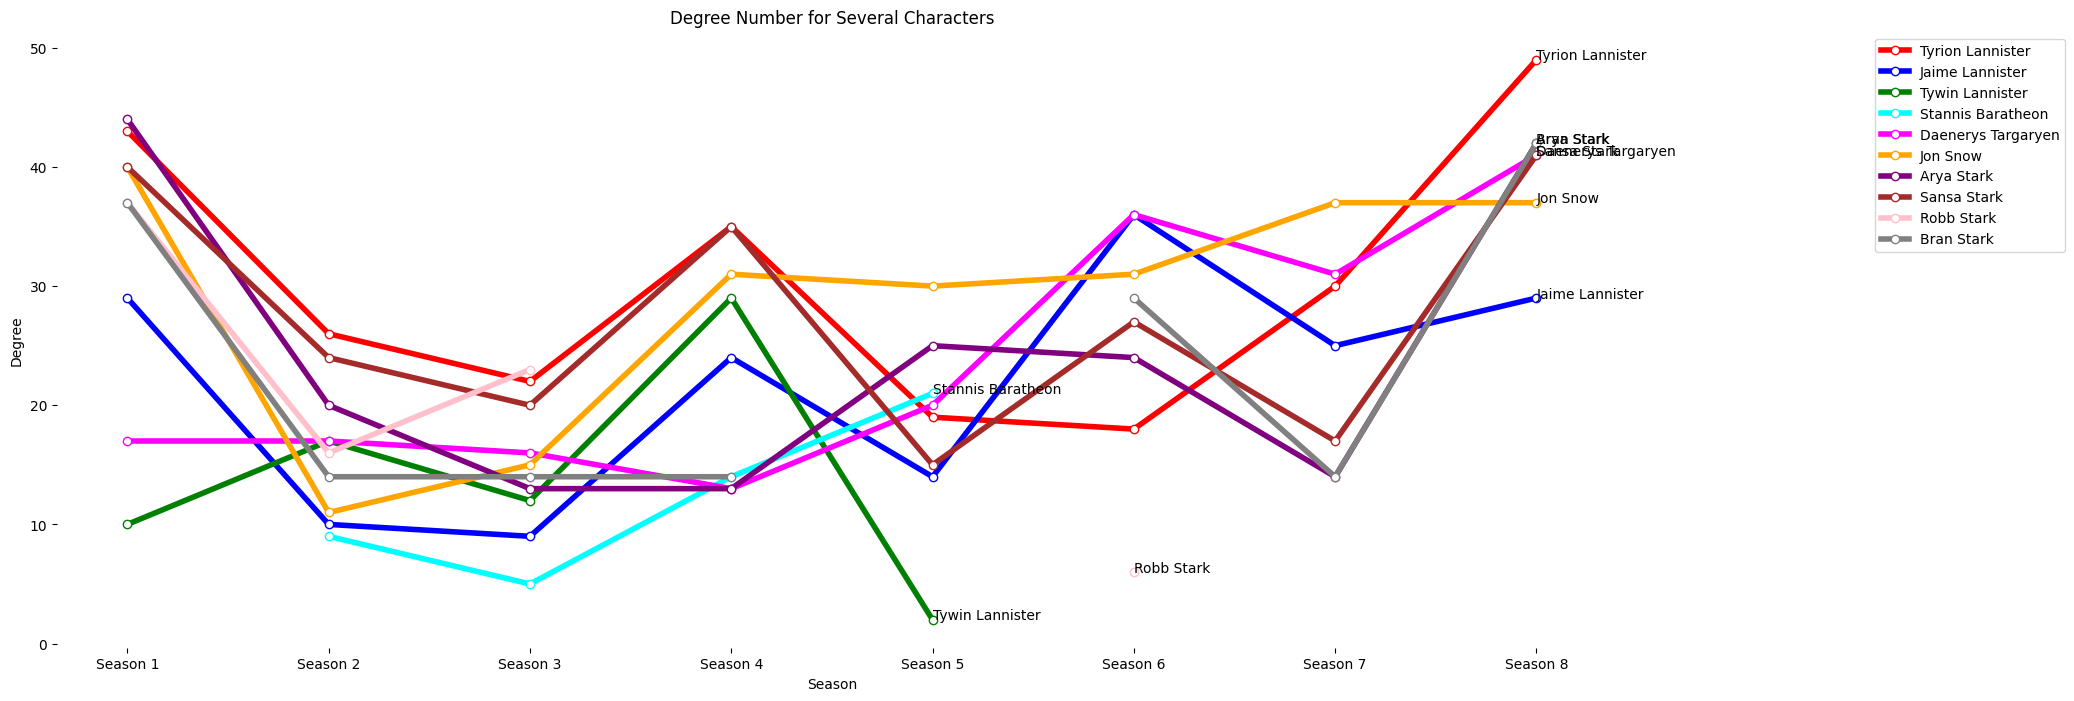

In [90]:
fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = (20, 10)

x_axis = [f"Season {i+1}" for i in range(len(season_graphs))]
#x_axis = [i+1 for i in range(len(season_graphs))]
for ele in chart_characters:
    name, ranks = ele["Name"], ele["Ranks"]
    ax.plot(
        x_axis,
        ranks,
        label=name,
        marker="o",
        markerfacecolor="white",
        color=ele["Color"],
        linewidth=4,
    )

    last_present_value = next(
        idx for idx, x in enumerate(reversed(ranks)) if x is not None
    )
    last_present_value = len(ranks) - last_present_value - 1

    ax.annotate(
        name,
        xy=(x_axis[last_present_value], ranks[last_present_value]),
        xytext=(x_axis[last_present_value], ranks[last_present_value]),
        #xy=(x_axis[last_present_value], ranks[last_present_value]),
        #xytext=(x_axis[last_present_value], ranks[last_present_value]),
        #textcoords="offset points"
    )

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xlabel("Season")
plt.ylabel("Degree")
plt.title("Degree Number for Several Characters")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.show()

# Sentiment Analysis of Game of Thrones


In [61]:
# Load Game_of_Thrones_Script.csv
df = pd.read_csv('../data/transcript/Game_of_Thrones_Script.csv', header=0, encoding='utf-8-sig')
sentiment_doc = pd.read_csv('../data/transcript/Data_Set_S1.txt', header=2, encoding='utf-8-sig', sep='\t')

print(df.head())

# Collect all the unique characters
characters = df['Name'].unique().tolist()

# Collect all unique episode titles
episodes = df['Episode Title'].unique().tolist()

# Collect all season numbers
seasons = df['Season'].unique().tolist()

  Release Date    Season    Episode     Episode Title          Name  \
0   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
1   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
2   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
3   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
4   2011-04-17  Season 1  Episode 1  Winter is Coming         gared   

                                            Sentence  
0  What do you expect? They're savages. One lot s...  
1  I've never seen wildlings do a thing like this...  
2                             How close did you get?  
3                            Close as any man would.  
4                   We should head back to the wall.  


In [63]:
# Create an empty list to collect all the lines said by each character per episode
lemmatizer = WordNetLemmatizer()
lines = []

# Create a for loop to loop through each character
for character in characters:
    # Create a temporary list to store the lines said by each character per episode
    character_lines = []
    # Create a for loop to loop through each episode
    for episode in seasons:
        # Create a temporary list to store the lines said by each character per episode
        episode_lines = []
        # Create a temporary dataframe to store the lines said by each character per episode
        temp_df = df[(df['Name'] == character) & (df['Season'] == episode)]
        # Create a for loop to loop through each line
        for line in temp_df['Sentence']:
            # Append the line to the temporary list
            episode_lines.append(line)
        # Append the temporary list to the temporary list
        episode_lines = ([lemmatizer.lemmatize(word) for word in episode_lines])
        character_lines.append(episode_lines)
    
    # Append the temporary list to the list
    lines.append(character_lines)

In [64]:
# Save the list as a pickle file
with open('../data/transcript/lines.pkl', 'wb') as f:
    pickle.dump(lines, f)

In [65]:
# Open the pickle file
with open('../data/transcript/lines.pkl', 'rb') as f:
    lines = pickle.load(f)

In [66]:
# Create an empty list to collect all the lines said by each character per episode
lines_split = []

lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

# Lowercase all the words in the list and remove punctuation. Lemmatize the words.
# Store the amount of words said by each character in total in a list
for character in lines:
    character_lines = []
    for episode in character:
        episode_lines = []
        for line in episode:
            line = line.lower()
            line = re.sub(r'[^\w\s]', '', line)
            line = ([word for word in line.split() if word not in stopwords])
            line = ([lemmatizer.lemmatize(word) for word in line])
            episode_lines.append(line)
        character_lines.append(episode_lines)
    lines_split.append(character_lines)

In [67]:
# For each character, get the sentiment score for each season
# Create an empty list to store the sentiment scores
character_sentiment = np.zeros((len(characters), len(seasons)))

# Create a for loop to loop through each character
for i in range(len(characters)):
    # Create a for loop to loop through each season
    for j in range(len(seasons)):
        for k in range(len(lines_split[i][j])):
            for l in range(len(lines_split[i][j][k])):
                # Create a temporary dataframe to store the sentiment score of each word
                temp_df = sentiment_doc[sentiment_doc['word'] == lines_split[i][j][k][l]]
                # If the word is in the sentiment_doc, add the sentiment score to the character_sentiment
                if len(temp_df) > 0:
                    character_sentiment[i][j] += temp_df['happiness_average'].values[0]/len(lines_split[i][j]) # Happiness average of the word / words per season

In [69]:
# Save the character_sentiment as a pickle file
with open('../data/transcript/character_sentiment.pkl', 'wb') as f:
    pickle.dump(character_sentiment, f)

In [70]:
# Open the pickle file
with open('../data/transcript/character_sentiment.pkl', 'rb') as f:
    character_sentiment = pickle.load(f)

In [91]:
chars = ["Tyrion Lannister", "Jaime Lannister", "Tywin Lannister", "Stannis Baratheon", "Daenerys Targaryen", "Jon Snow", "Arya Stark", "Sansa Stark", "Robb Stark", "Bran Stark"]
args = [characters.index(char.lower()) for char in chars]

sentis = [character_sentiment[arg] for arg in args]

In [92]:
lists_of_char = [
    {
        'Name': 'Tyrion Lannister',
        'Rank': sentis[0],
        'Color': 'red'
    },
    {
        'Name': 'Jaime Lannister',
        'Rank': sentis[1],
        'Color': 'blue'
    },
    {
        'Name': 'Tywin Lannister',
        'Rank': sentis[2],
        'Color': 'green'
    },
    {
        'Name': 'Stannis Baratheon',
        'Rank': sentis[3],
        'Color': 'cyan'
    },
    {
        'Name': 'Daenerys Targaryen',
        'Rank': sentis[4],
        'Color': 'magenta'
    },
    {
        'Name': 'Jon Snow',
        'Rank': sentis[5],
        'Color': 'orange'
    },
    {
        'Name': 'Arya Stark',
        'Rank': sentis[6],
        'Color': 'purple'
    },
    {
        'Name': 'Sansa Stark',
        'Rank': sentis[7],
        'Color': 'brown'
    },
    {
        'Name': 'Robb Stark',
        'Rank': sentis[8],
        'Color': 'pink'
    },
    {
        'Name': 'Bran Stark',
        'Rank': sentis[9],
        'Color': 'grey'
    }
]

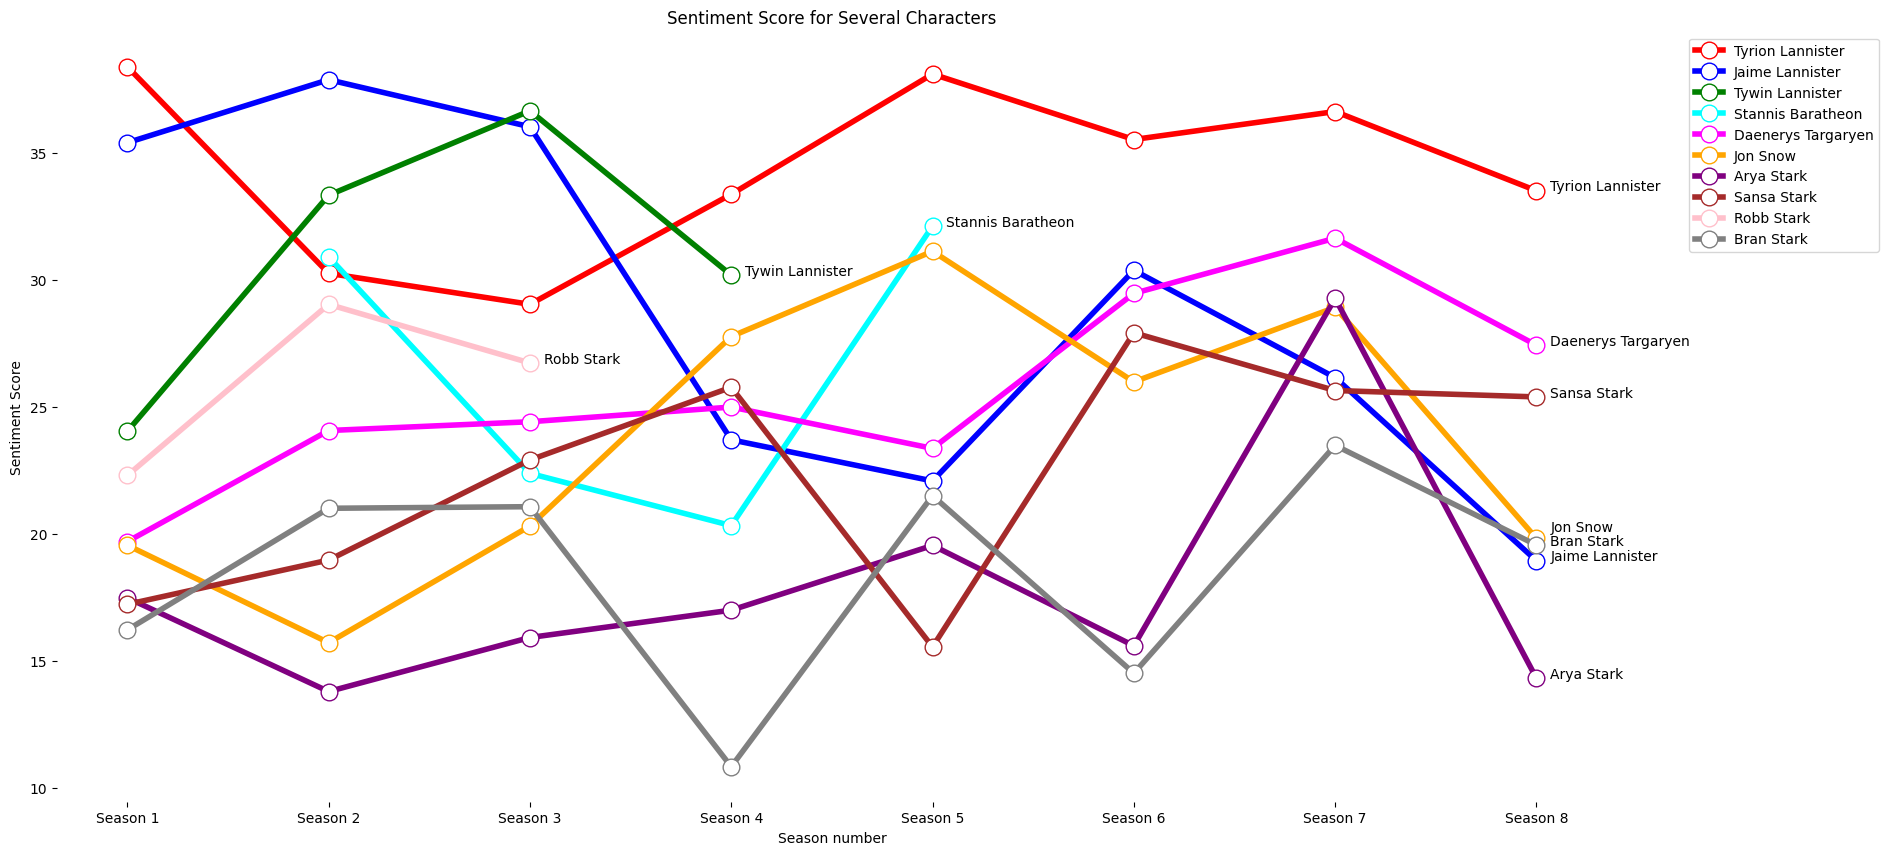

In [93]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,100)

for element in lists_of_char:
    # if element is either 0 or inf, set it to nan
    element['Rank'][element['Rank'] == 0] = np.nan
    ax.plot(seasons, element['Rank'], label=element['Name'], marker='o', markerfacecolor='white', markersize=12, color=element['Color'], linewidth=4)
    # Remove elements with sentiment score of 0
    xy = (7, element['Rank'][-1])
    # If element has a sentiment score of nan, set xy to the previous element that is not nan
    if np.isnan(xy[1]):
        for i in range(len(element['Rank'])-1, -1, -1):
            if not np.isnan(element['Rank'][i]):
                xy = (i, element['Rank'][i])
                break
    
    xytext = (10, 0)
    if element['Name'] == 'Jon Snow':
        xytext = (10, 5)

    ax.annotate(element['Name'], xy=xy, xytext=xytext, textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.ylabel('Sentiment Score')
plt.xlabel('Season number')
plt.title('Sentiment Score for Several Characters')
plt.legend(loc = 'upper right' , bbox_to_anchor = (1.18, 1))
plt.show()